## Estimating envelope functions

Core idea is the "isotropy principle": the marginal distributions of any $\theta$ should be the same at any chosen pitch period. But *joint* draws of $p(\theta|\alpha)$ are heavily correlated by the envelope correlation kernel $k(i,j)$ learned from real data. We assume source and filter have different envelope kernels.

Note 1: for the pitch period envelope, we can make definite predictions about jitter and shimmer values.

### Envelope learning from Praat estimates

In principle we work with fixed hyperparameters $\hat \alpha$, and predict $p(\theta|\hat\theta,\hat\alpha)$ using a conditioned Gaussian process. In other words, we do not adjust the envelope $\lambda$ or Praat estimation noise $\delta^2$ based on Praat's estimate for the data at hand.

But we could also learn the envelope from $\hat\theta$ by doing MAP over $\alpha$ starting from $\hat\alpha$ or even using nested sampling using $p(\alpha|D)$ as a prior for $\alpha$, where $D$ is the relevant TIMIT dataset. In other words, we learn the envelope parameters $\alpha$ from TIMIT and can represent this information either as a delta prior $p(\alpha|D) = \delta(\alpha-\hat\alpha)$, or retain the uncertainty, e.g. as a Gaussian $p(\alpha|D) = N(\alpha;\hat\alpha,\sigma_\alpha^2)$.

In [1]:
%run init.ipy
import pandas as pd

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

This database gives larynx frequency and voicing information
on the core subset of the TIMIT waveform files. This comproses 192
files in the "Test" set and 72 files in the "Train" set.

Format of data:

The waveform is divided into non-overlapping frames on unequal lengths.
The fxv file contains a single row for each frame containing four numerical
values: t1 t2 type fx.
* t1 and t2 give the starting and ending sample numbers of the frame. The first
  sample in the file is numbered 0 and t2 in one frame equals t1 in the next frame.
* type is an integer in the range 0 to 3: 0 = silent, 1 = unvoiced, 2 = normal voiced
  and 3 = bicyclic or irregular. In bicyclic voicing, larynx cycles are alternately 
  longer and shorter than the average.
* fx is the fundamental frequency (or pitch). For bicyclic intervals, fx is the
  reciprocal of the average cycle duration.

From Mehta (2012), about the VTRFormants database:

> A frame is considered silent if all its samples are labeled as a pause (pau, epi, h#), closure interval (bcl, dcl, gcl, pcl, tcl, kcl ), or glottal stop (q).

So we include voiced and unvoiced speech and only exclude silent frames, as to be compatible with the VTRFormants database as used by Metha (2012).

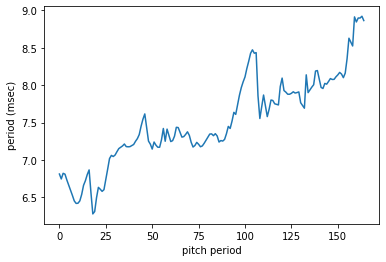

In [2]:
fxv = pd.read_csv("dgf/test/SI1194.fxv", delim_whitespace=True, header=None, names=("t1", "t2", "type", "fx"))

fxv["T"] = 1/fxv.fx*1000 # msec

data_raw = fxv[fxv.type != 0]["T"]
data_raw = jnp.asarray(data_raw)

plot(data_raw)
xlabel("pitch period")
ylabel("period (msec)");

5.7058734841341375e-15 0.9999999999999999


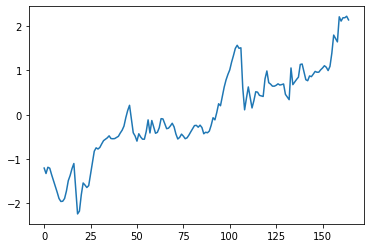

In [3]:
def bounded_exp_bijector(low, high, hinge_factor=0.01):
    low = jnp.float64(low)
    high = jnp.float64(high)
    
    # The hinge softness must be smaller than O(low); the default value
    # `hinge_softness == 1` implies that the range of the constrained
    # values (i.e., in the forward direction) is O(1). If this is not the
    # case, the default value will cause numerical problems or prevent the
    # entire constrained range to be reachable from [-inf, +inf]. You can
    # check if this is the case by evaluating `b.forward(-inf), b.forward(+inf)`
    # where `b = bounded_exp_bijector(low, high, hinge_factor)`.
    hinge_softness = hinge_factor * jnp.abs(low)
    return tfb.Chain([tfb.SoftClip(low, high, hinge_softness), tfb.Exp()])

def colored_bijector(mean, std):
    """Unwhiten (color) a real variable"""
    return tfb.Chain([tfb.Shift(mean), tfb.Scale(std)])

def colored_bounded_exp_bijector(y, low, high):
    """
    Forward transform a whitened real variable to a positive and bounded variable `y`
    
    Note: the `low` and `high` arguments must be comfortably smaller, respectively
    larger than the extreme values of `y`, or the `SoftClip()` operation will yield
    nan values.
    """
    b = bounded_exp_bijector(low, high)
    x = b.inverse(y)
    c = colored_bijector(x.mean(), x.std())
    return tfb.Chain([b, c])

low = 1000/350
high = 1000/50

cb = colored_bounded_exp_bijector(data_raw, low, high)

data_transformed = cb.inverse(data_raw)

plot(data_transformed)

print(data_transformed.mean(), data_transformed.std())

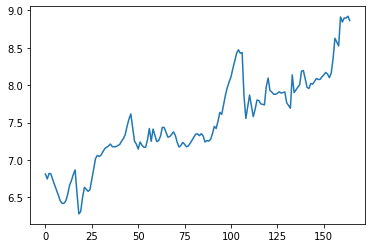

In [4]:
plot(cb.forward(data_transformed))

GP_regression.,value,constraints,priors
Mat32.variance,0.8027402722603885,+ve,
Mat32.lengthscale,6.94251731512519,+ve,
Gaussian_noise.variance,0.005386331088037321,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f31282fd6d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f31201ee5b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f31201ee760>]}

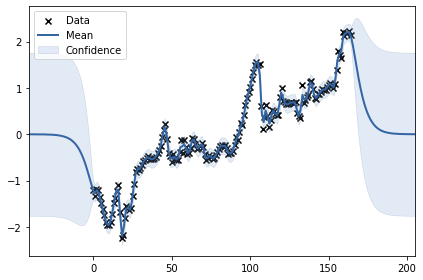

In [5]:
import GPy

X = np.arange(len(data_transformed))[:,None]
Y = data_transformed[:,None]
kernel = GPy.kern.Matern32(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)
m.optimize()
display(m)
m.plot()

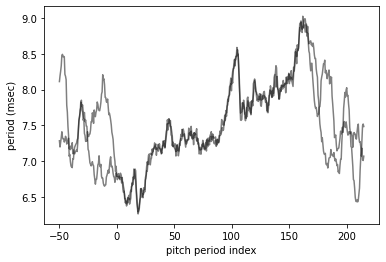

In [6]:
size = 2
Xpred = np.linspace(-50, len(data_transformed) + 50, 500)[:,None]
mean, covar = m.predict(Xpred, full_cov=True)
F_transformed = multivariate_normal(mean[:,0], covar, size=size)
for curve in F_transformed:
    F = cb.forward(curve)
    plot(Xpred, F, alpha=1/size, color='black');
#plot(formants, ls=':');
xlabel("pitch period index")
ylabel("period (msec)");

## Formants

In [7]:
import struct
import numpy as np

# https://github.com/lemnzhou/htkIO/blob/master/htkIO.py
def htkread(filename):
    '''
    nframe -- frame number
    frate -- sample ratio
    ndim -- feature dimension
    feakind -- fea kind
    '''
    fid = open(filename, 'rb')
    readbytes = fid.read()
    fid.close()
    nframe = readbytes[0:4]
    #unpack return a tuple,whether it's necessarily to reversed the byte array depend on your machine.
    nframe,= struct.unpack('i',bytes(reversed(nframe)))
    frate  = readbytes[4:8]
    frate, = struct.unpack('i',bytes(reversed(frate)))
    ndim  = readbytes[8:10]
    ndim, = struct.unpack('h',bytes(reversed(ndim)))
    ndim /= 4
    ndim = int(ndim)
    nframe = nframe
    data = np.zeros((ndim,nframe))
    feakind = readbytes[10:12]
    feakind = struct.unpack('h',bytes(reversed(feakind)))
    feakind = int(feakind[0])
    startIndex = 12
    for i in range(nframe):
        for j in range(ndim):
            value = readbytes[startIndex:startIndex+4]
            value, = struct.unpack('f',bytes(reversed(value)))
            data[j][i] = value
            startIndex += 4
    return [data,frate,feakind]

formant_data, frate, feakind = htkread("dgf/test/si1149.fb")
formant_data.shape

(8, 361)

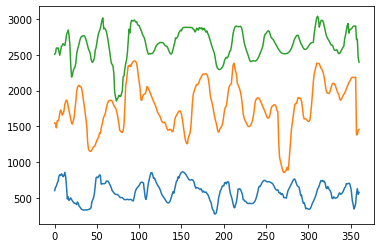

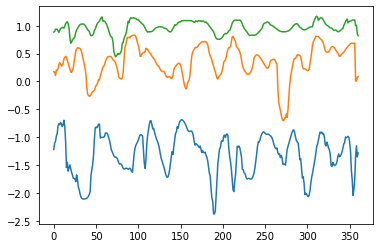

In [8]:
# For some **extremely** obscure reason, this only works with Hz values (UPDATE: this is fixed, no need anymore to rescale)
# The SoftClip() function is sensitive to scale.
# But we whiten anyway, so it does not matter
formants = formant_data[:3,:].T * 1000 # Hz
plot(formants)
figure()
plot(colored_bounded_exp_bijector(formants, 100., 5000.).inverse(formants));

In [9]:
import GPy

bijector = colored_bounded_exp_bijector(formants, 100., 5000.)
transformed_formants = bijector.inverse(formants)

n, m = transformed_formants.shape
n_obs = n*m
X = np.zeros((n*m, 2), dtype=int)
Y = np.zeros((n*m, 1))
k = 0
for i in range(n):
    for j in range(m):
        X[k, :] = [i,j] # (pitch period, formant m)
        Y[k] = transformed_formants[i,j]
        k += 1

#X = np.indices(formants.shape).reshape(n_obs, 2, order='F')
#Y = formants.reshape(n_obs, 1, order='F')

In [10]:
# Check
i = 1000
x, y = X[i,:]
X[i,:], (x,y), Y[i,:], transformed_formants[x,y]

(array([333,   1]),
 (333, 1),
 array([0.57734753]),
 DeviceArray(0.57734753, dtype=float64))

In [11]:
# https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb
kernel = GPy.kern.Matern32(input_dim=2, ARD=True)
model = GPy.models.GPRegression(X,Y,kernel)
model.optimize(messages=True)

In [12]:
model

GP_regression.,value,constraints,priors
Mat32.variance,0.7072153922853599,+ve,
Mat32.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.00044332741082569343,+ve,


In [13]:
model.kern.lengthscale

index,GP_regression.Mat32.lengthscale,constraints,priors
[0],16.31928919,+ve,
[1],0.14324234,+ve,


 /home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f312830b550>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f312831f4f0>]}

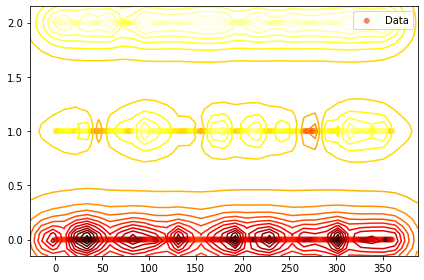

In [14]:
model.plot()

{'gpmean': [[<matplotlib.lines.Line2D at 0x7f311059fa90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f311059fc40>]}

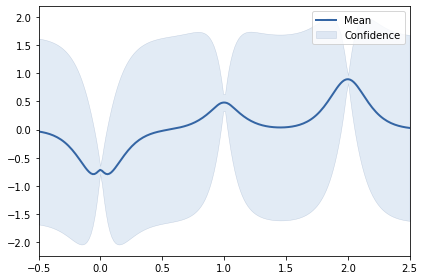

In [15]:
pitch_period_index = 115
model.plot(fixed_inputs=[(0,pitch_period_index)], plot_data=False)

{'gpmean': [[<matplotlib.lines.Line2D at 0x7f311051b2b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f311051b460>]}

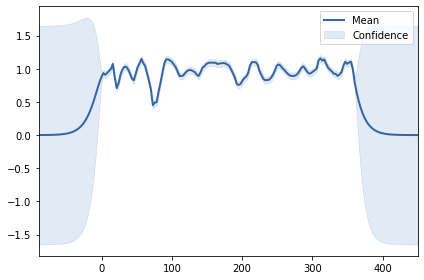

In [16]:
formant_index = 2 # F3
model.plot(fixed_inputs=[(1,formant_index)], plot_data=False)

In [17]:
bijector.forward(model.posterior_samples(X[200,][None,:]))

DeviceArray([[[2463.07616684, 2514.01873458, 2470.47689925,
               2455.90142351, 2398.39132216, 2411.96964256,
               2519.24918939, 2399.12104555, 2541.54249094,
               2471.92460554]]], dtype=float64)

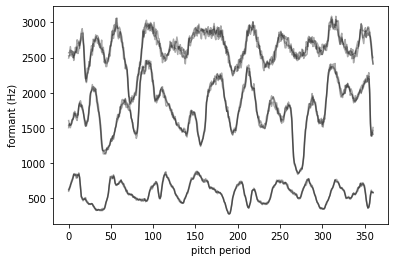

In [18]:
size = 3
mean, covar = model.predict(X, full_cov=True)
F_transformed = multivariate_normal(mean[:,0], covar, size=size)
for curve in F_transformed:
    F = bijector.forward(curve)
    plot(F.reshape(n, m), alpha=1/size, color='black');
#plot(formants, ls=':');
xlabel("pitch period")
ylabel("formant (Hz)");

### Prior mean and coveriances for the VTR frequencies

Estimation of prior mean and covariances for the VTR frequencies in the latent log space. Notes:
- The latent MVN in log space is highly correlated and encodes approximately the ordering of the VTRs;
- This correlation should be taken into account.
- The latent MVN in log space underestimates the fat tails of the true distribution of `p(log x)` (which looks similar to a Landau distribution). Thus the VTR frequencies tend to be shy of higher frequencies (say > 2000 Hz). I don't think this will be a problem, as there is still mass at these higher frequencies, but if this turns out to be one, we could apply a FITC-like diagonal correction to the covariance matrix.
- We don't use the pdf weights in estimating the mean and covariance matrices because the correct pdfs of the *truncated* distribution `sample_truncated()` require to evaluate an integral that I don't have time to evaluate
- **Units.** Our log log transformation is not fully kosher because we are log transforming quantities which are not dimensionless. It is indeed possible to do this more properly by log transforming ratios of successive VTR frequencies, as in the Pareto chain prior, but then we cannot guarantee anymore the "isotropy principle", i.e., that the marginal means and variances are constant and do not depend on the particular pitch period chosen. I've also seen MacKay do this, so it's not too bad.

array([5.40888159, 5.86822718, 6.18471774])

array([[0.49865011, 0.47514003, 0.46421366],
       [0.47514003, 0.64904668, 0.6351685 ],
       [0.46421366, 0.6351685 , 0.71929722]])

DeviceArray([515.51050284, 421.73426798, 569.88347397], dtype=float64)

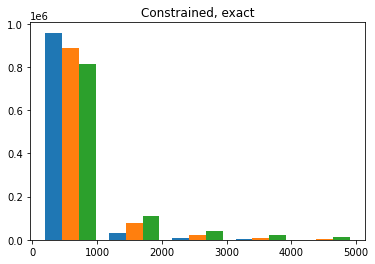

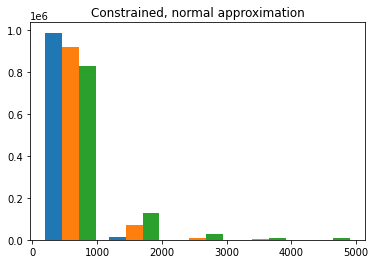

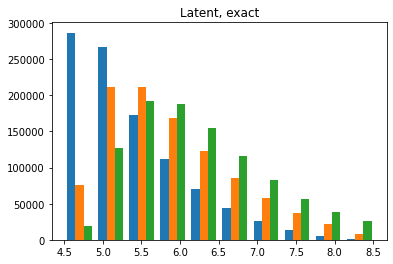

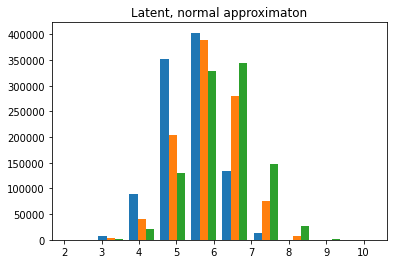

In [19]:
from vtr import sample as paretochain
from dynesty import utils as dyfunc

def getx(nx, x0, fs, size=1):
    xmax = fs/2
    xbar = x0 + (xmax - x0)/(nx+1)*np.arange(1, nx+1)
    #xbar = 500*np.arange(1, nx+1)
    x = paretochain.sample_truncated(x0, xbar, xmax, size=size)
    return x

size = int(1e6)
npoles = 3
x0 = 100
fs = 10000

x = getx(npoles, x0, fs, size)
b = bounded_exp_bijector(x0, fs/2, hinge_factor=0.01)
y = asarray(b.inverse(x)) # Latent

mean, cov = dyfunc.mean_and_cov(y, ones(size)/size)
display(mean, cov) # Strongly correlated

ya = multivariate_normal(mean, cov, size=size)
xa = b.forward(multivariate_normal(mean, cov, size=size))

figure()
title("Constrained, exact")
hist(x, bins=5);

figure()
title("Constrained, normal approximation");
hist(asarray(xa), bins=5);

figure()
title("Latent, exact")
hist(y);

figure()
title("Latent, normal approximaton")
hist(ya);

# Sample from the normal approximation
xa[randint(size),:]

### VTR frequency trajectories

The covariance function $k([r,i],[s,j]) = k(r,s) k(i,j)$ has Kronecker structure. $k(r,s)$ is the covariance between VTR with indices $r$ and $s$. $k(i,j)$ is the *correlation* (i.e., has unit marginal variance) envelope.

In [20]:
mean, cov

(array([5.40888159, 5.86822718, 6.18471774]),
 array([[0.49865011, 0.47514003, 0.46421366],
        [0.47514003, 0.64904668, 0.6351685 ],
        [0.46421366, 0.6351685 , 0.71929722]]))

In [21]:
num_pitch_periods = 350
I = jnp.arange(num_pitch_periods)

envelope_lengthscale = 7.
K_envelope = exp(-(I[:,None] - I[None,:])**2/(2*envelope_lengthscale**2))

K_full = jnp.kron(cov, K_envelope)
mean_full = jnp.kron(mean, jnp.ones(num_pitch_periods))

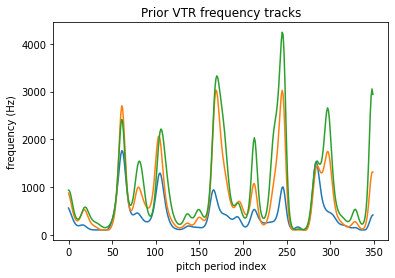

In [22]:
latent_trajectories = multivariate_normal(mean_full, K_full).reshape(npoles, num_pitch_periods)

plot(b.forward(latent_trajectories).T)
title('Prior VTR frequency tracks')
xlabel('pitch period index')
ylabel('frequency (Hz)');

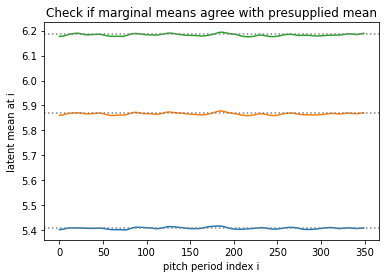

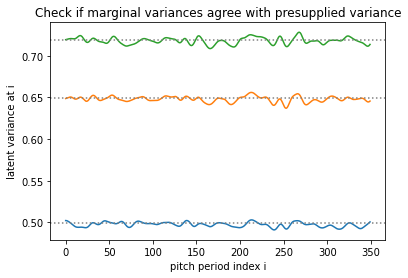

In [23]:
a = multivariate_normal(mean_full, K_full, size=50000).reshape(-1, npoles, num_pitch_periods)
plot(np.mean(a, axis=0).T)
for mi in mean: axhline(mi, ls=':', color='grey')
title('Check if marginal means agree with presupplied mean')
xlabel('pitch period index i')
ylabel('latent mean at i')

figure()
plot(np.var(a, axis=0).T)
for vi in diag(cov): axhline(vi, ls=':', color='grey')
title('Check if marginal variances agree with presupplied variance')
xlabel('pitch period index i')
ylabel('latent variance at i');

In [24]:
# All good!